In [1]:
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
sns.set_style('whitegrid')
from sklearn.metrics import confusion_matrix , classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Flatten , Conv2D , MaxPooling2D , Dropout , Activation , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers
# TensorFlow: Makine öğrenimi ve derin öğrenme için açık kaynaklı bir platformdur.
# Keras: Yüksek seviyede bir derin öğrenme API'sidir. TensorFlow, Theano veya CNTK gibi farklı arka uçlarda çalışabilir.
#Uyarı
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import pandas as pd
#dataset https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images
colon_data = ''
# Veri çerçevesi oluşturma işlevi
def create_dataframe(data_path):
    # Dosya yolları ve etiketleri saklamak için liste
    filepaths = []
    labels = []

    # Mevcut veri yolu içindeki tüm alt klasörleri listeleme
    folds = os.listdir(data_path)
    
    # Her bir alt klasör üzerinde döngü
    for fold in folds:
        f_path = os.path.join(data_path, fold)
        imgs = os.listdir(f_path)
        
        # Alt klasördeki her bir resim üzerinde döngü
        for img in imgs:
            img_path = os.path.join(f_path, img)
            
            # Resim yolunu ve ilgili etiketi ekleme
            filepaths.append(img_path)
            labels.append(fold)

    # Dosya yolları ve etiketler için Pandas Serisi oluşturma
    fseries = pd.Series(filepaths, name='Filepaths')
    lseries = pd.Series(labels, name='Labels')
    return pd.concat([fseries, lseries], axis=1)

# Kolon verisi için DataFrame oluşturma
colon_df = create_dataframe(colon_data)


In [ ]:
final_df = pd.concat([colon_df], ignore_index=True)
final_df

In [4]:
# Veri setini eğitim, doğrulama ve test kümelerine ayırma
from sklearn.model_selection import train_test_split
train_df, dummy_df = train_test_split(final_df,  train_size= 0.8, shuffle= True, random_state= 42)
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 42)

In [5]:
# Eğitim verisi için veri artırma
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Piksel değerlerini [0, 1] aralığına yeniden ölçeklendirme
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
# Doğrulama ve test için yalnızca yeniden ölçeklendirme
valid_datagen = ImageDataGenerator(rescale=1./255)  
test_datagen = ImageDataGenerator(rescale=1./255)

# Eğitim verisi için flow_from_dataframe üreteci oluşturma
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(150, 150),
    batch_size=50,
    class_mode='categorical',  
    shuffle=True,
    seed=42
)

# Doğrulama verisi için flow_from_dataframe üreteci oluşturma
valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(150, 150),
    batch_size=50,
    class_mode='categorical',
    shuffle=False  
)

# Test verisi için flow_from_dataframe üreteci oluşturma
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(150, 150),
    batch_size=50,
    class_mode='categorical',
    shuffle=False 
)


Found 8000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.


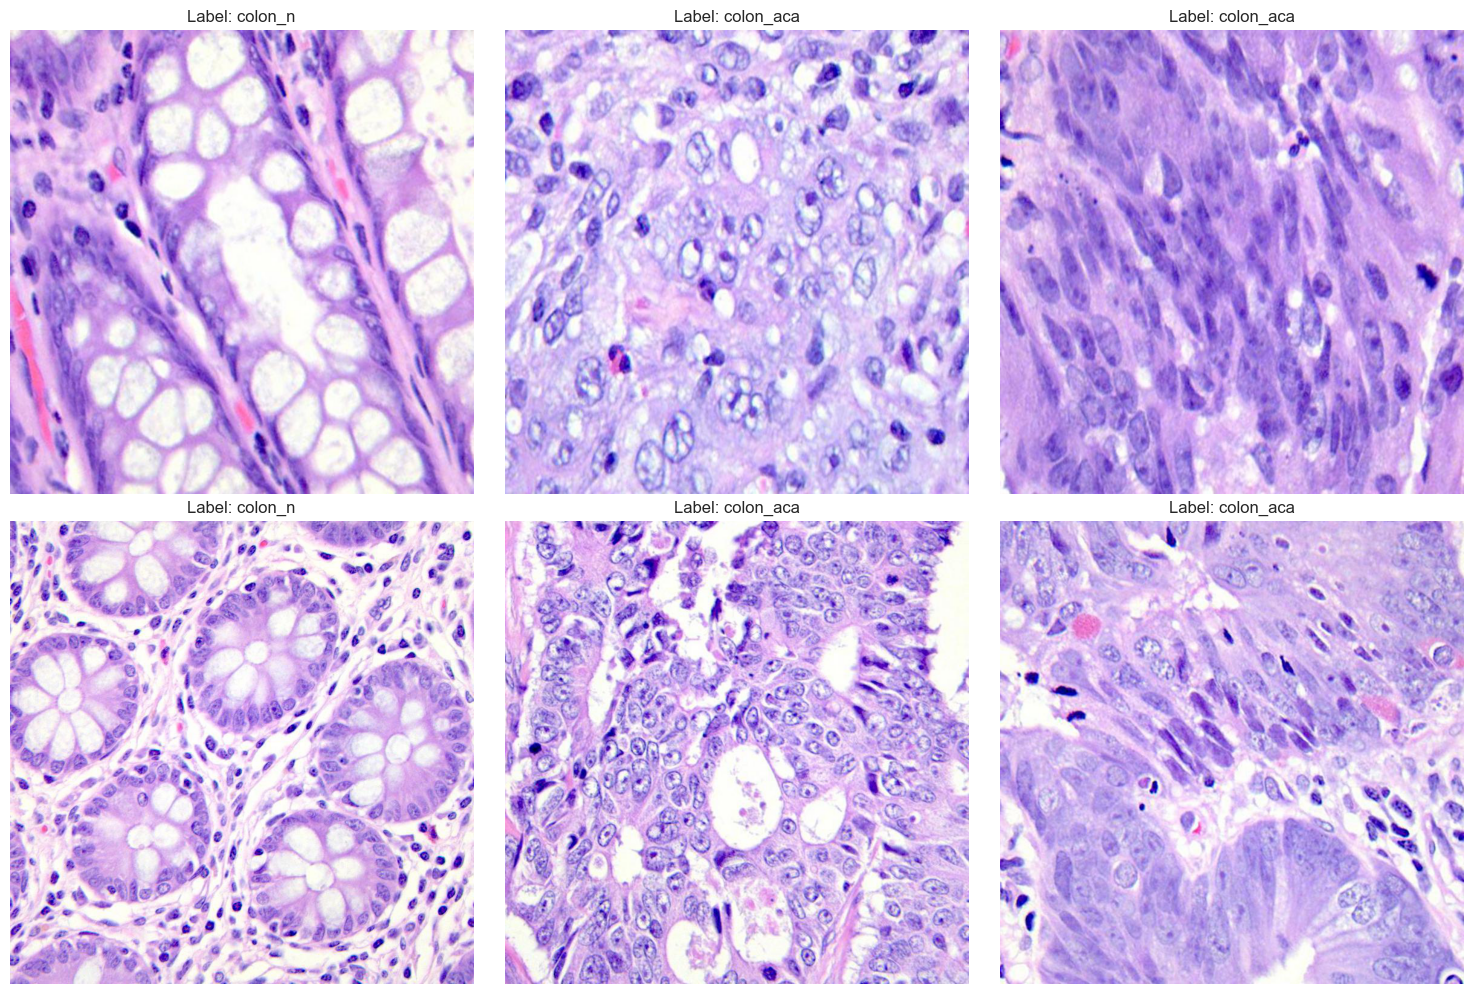

In [6]:
import random

# Etiketleriyle birlikte görüntülerin çizilmesi
def plot_samples(df, num_samples=6):
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        # Rastgele bir resim seç
        rand_idx = random.randint(0, len(df) - 1)
        img_path = df.iloc[rand_idx]['Filepaths']
        label = df.iloc[rand_idx]['Labels']
        
        # Resmi oku ve çiz
        img = plt.imread(img_path)
        plt.subplot(2, 3, i+1)
        plt.imshow(img)
        plt.title(f'Label: {label}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

plot_samples(train_df)

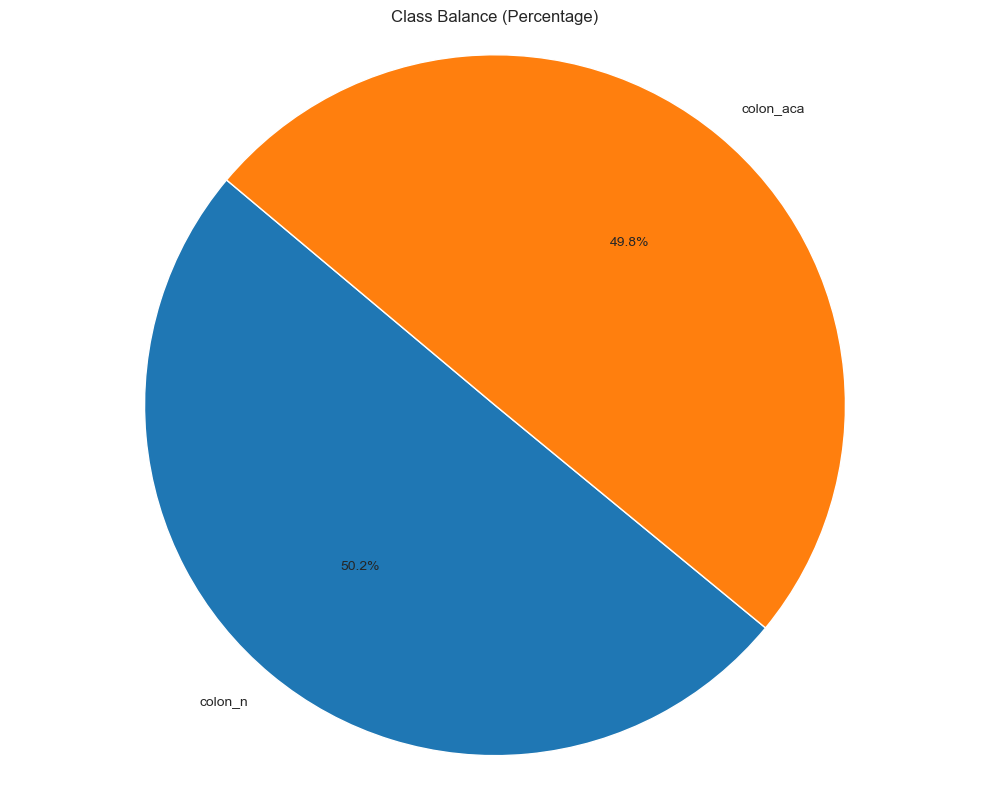

In [7]:
# Sınıf sayılarını hesaplama
class_counts = train_df['Labels'].value_counts().reset_index()
class_counts.columns = ['Class', 'Count']

# Eğitim veri kümesindeki toplam görüntü sayısını hesaplama
total_images = len(train_df)

# Her sınıf için toplam görüntü sayısına göre yüzdeyi hesaplama
class_counts['Percentage'] = (class_counts['Count'] / total_images) * 100

# Sayıya göre veri çerçevesini sıralama
class_counts = class_counts.sort_values(by='Count', ascending=False)

# Matplotlib kullanarak pasta grafiği oluşturma
plt.figure(figsize=(10, 8))
plt.pie(class_counts['Percentage'], labels=class_counts['Class'], autopct='%1.1f%%', startangle=140)
plt.title('Class Balance (Percentage)')
plt.axis('equal')  
plt.tight_layout()
plt.show()

In [8]:
# Xception modelinin temel model olarak kullanılması
base_model = tf.keras.applications.xception.Xception(weights= 'imagenet' ,include_top = False , input_shape = (150,150,3) ,
                                                     pooling = 'max' )
# Yeni modelin oluşturulması
model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(256,activation = 'relu'),
    Dropout(.5),
    Dense(2 , activation= 'softmax' )
])
# Modelin derlenmesi
model.compile(Adamax(learning_rate = 0.001) , loss = 'categorical_crossentropy' , metrics= ['accuracy'])
# Modelin eğitilmesi
history = model.fit(
    x= train_generator ,
    validation_data= valid_generator ,
    epochs= 2 , verbose = 1 ,
    validation_steps= None, shuffle= False
   )

Epoch 1/2
160/160 ━━━━━━━━━━━━━━━━━━━━ 612s 4s/step - accuracy: 0.9533 - loss: 0.1492 - val_accuracy: 0.9980 - val_loss: 0.0035
Epoch 2/2
160/160 ━━━━━━━━━━━━━━━━━━━━ 586s 4s/step - accuracy: 0.9929 - loss: 0.0168 - val_accuracy: 1.0000 - val_loss: 1.7061e-04


In [9]:
# Test verisi üzerinde modelin değerlendirilmesi
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Accuracy:", test_accuracy)

20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 804ms/step - accuracy: 1.0000 - loss: 3.0810e-04
Test Accuracy: 1.0


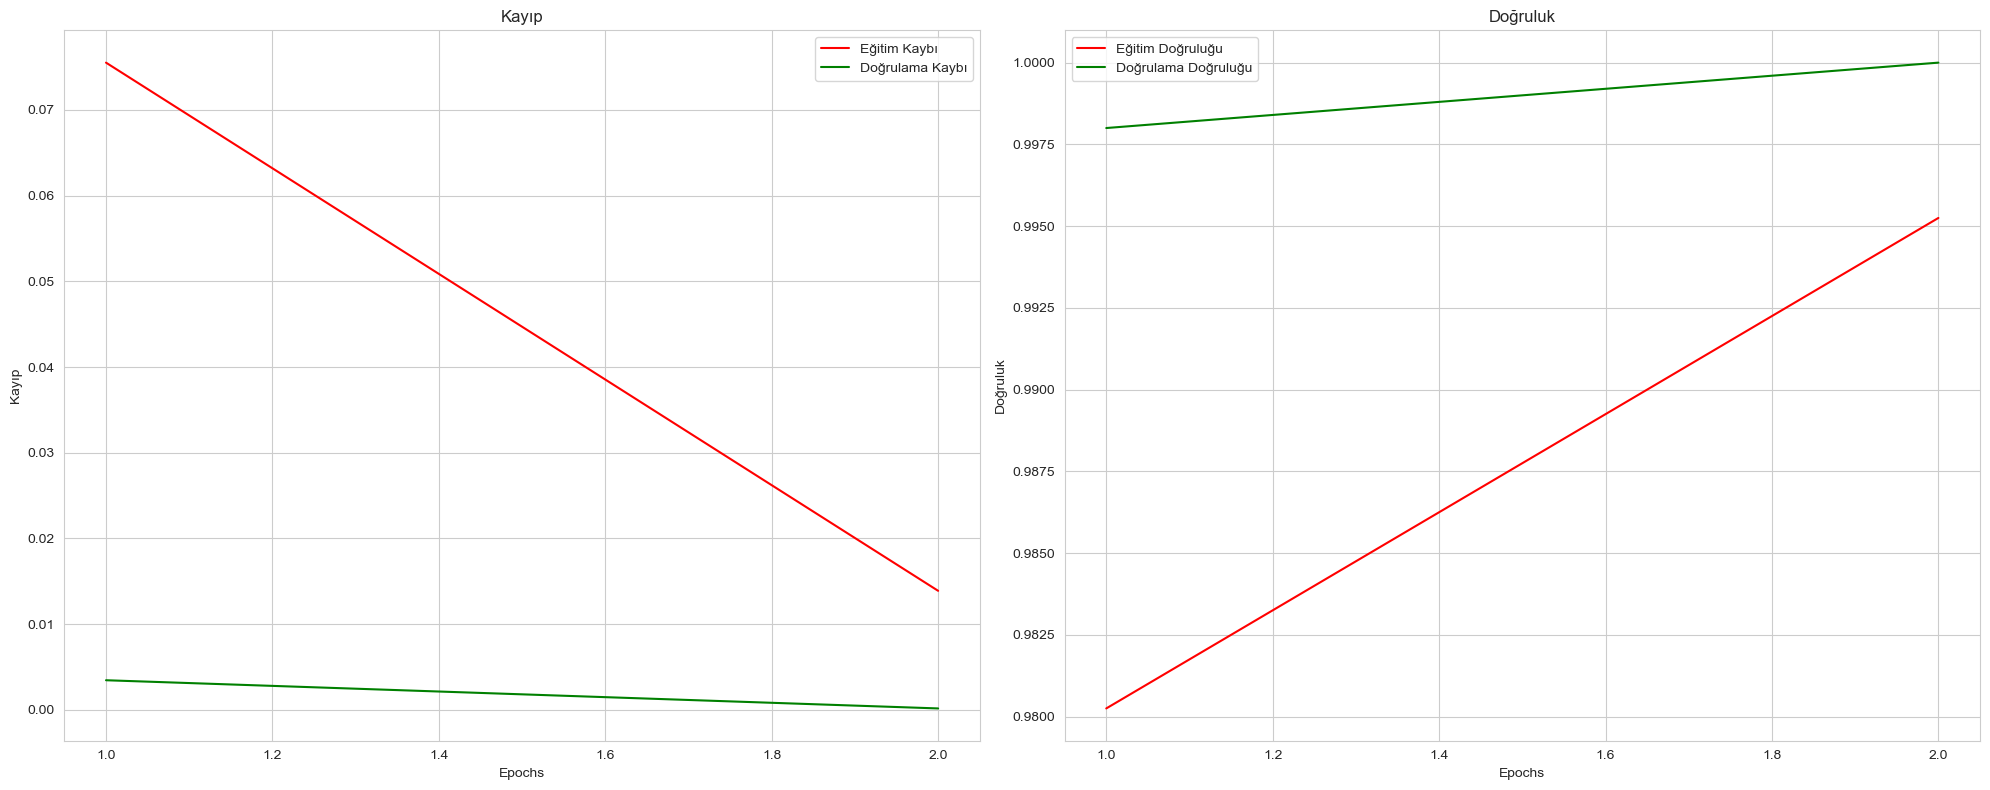

In [10]:
# Eğitim sürecinde elde edilen metriklerin çizdirilmesi
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = [i+1 for i in range(len(tr_acc))]

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs, tr_loss, 'r', label='Eğitim Kaybı')
plt.plot(epochs, val_loss, 'g', label='Doğrulama Kaybı')
plt.title('Kayıp')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Kayıp')

plt.subplot(1, 2, 2)
plt.plot(epochs, tr_acc, 'r', label='Eğitim Doğruluğu')
plt.plot(epochs, val_acc, 'g', label='Doğrulama Doğruluğu')
plt.title('Doğruluk')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Doğruluk')

plt.tight_layout()
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 788ms/step


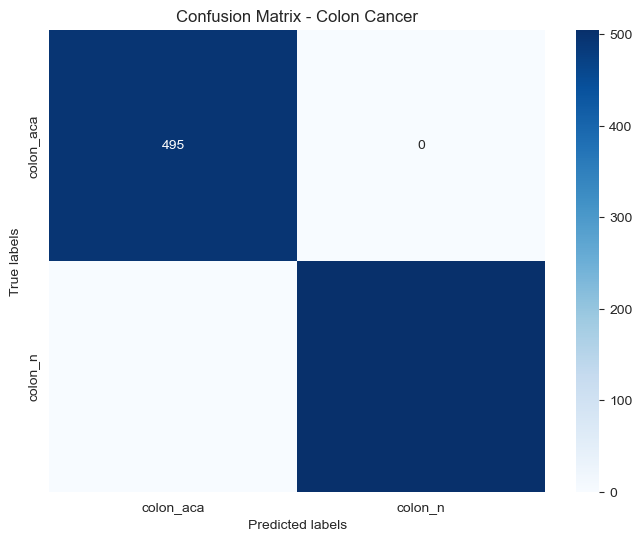

Classification Report:
               precision    recall  f1-score   support

   colon_aca       1.00      1.00      1.00       495
     colon_n       1.00      1.00      1.00       505

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



In [11]:
# Tahmin
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)

# Gerçek etiketler
y_true = test_generator.classes

# Confusion matrisinin hesaplanması
conf_matrix = confusion_matrix(y_true, y_pred)

# Karışıklık matrisinin çizdirilmesi
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=test_generator.class_indices.keys(), 
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - Colon Cancer')
plt.show()


# Sınıflandırma raporunun oluşturulması
class_report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys())

print("Classification Report:\n", class_report)


Random bir numuneyi atama ve numunenin kolon kanseri olup olmadığını tahmin edilmesi.

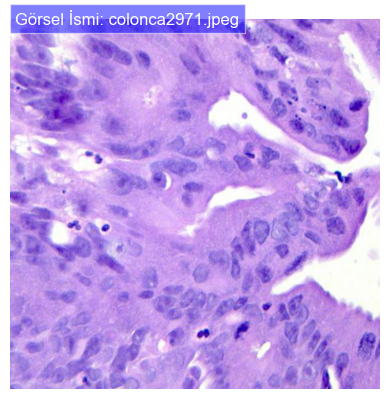

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


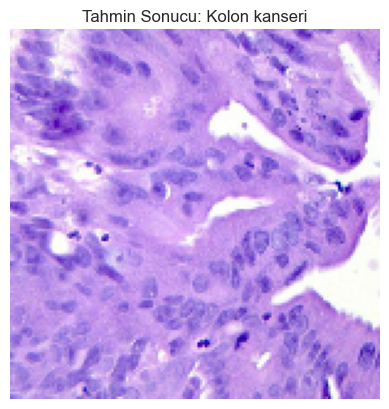

In [14]:
# Random bir numune seçme
random_sample = test_df.sample(n=1).iloc[0]

# Numune yolunu ve etiketini alıyoruz
sample_path = random_sample['Filepaths']
sample_label = random_sample['Labels']

# Seçilen numuneyi gösterme
sample_img = plt.imread(sample_path)
plt.imshow(sample_img)
plt.text(10, 10, f'Görsel İsmi: {os.path.basename(sample_path)}', color='white', fontsize=12, bbox=dict(facecolor='blue', alpha=0.5))
plt.axis('off')
plt.show()
# Numunenin modelde kullanılması ve tahmin yapılması
if sample_img is not None:
    # Görseli yeniden boyutlandırma
    sample_img = cv2.resize(sample_img, (150, 150))
    sample_img = np.expand_dims(sample_img, axis=0) / 255.0  # Rescale

    # Tahmin yapma
    prediction = model.predict(sample_img)
    predicted_label = "Kolon kanseri" if np.argmax(prediction) == 0 else "Kolon kanseri değil"

    # Tahmin sonucunu gösterme
    plt.imshow(sample_img[0])
    plt.title(f'Tahmin Sonucu: {predicted_label}')
    plt.axis('off')
    plt.show()
else:
    print("Görsel okunamadı. Lütfen dosya yolunu kontrol edin.")
